### Problem Statement:

Research Question: Can the performance of random grid sampling for hyperparameter optimization be enhanced by incorporating a surrogate model?

Importing the necessary libraries and tools.

### Required Libraries: Will be using libraries like pandas, scikit-learn, and XGBoost. 

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import xgboost as xgb
import random
import warnings
from xgboost import XGBRegressor
from IPython.display import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



### Step 1: Data Preparation

- Loading and preprocessing the dataset.
- Splitting the dataset into training and testing sets. An 80-20 split is used.

In [47]:
## Loading the Data and showing the dimension or shape of the dataset

df = pd.read_csv('adverts.csv')

df.shape


(402005, 12)

Summary
The raw dataset contains 402,005 records.
It consists of 12 columns, each representing different aspects of information about vehicles.

### Checking Correct Parsing of Data

In [48]:
# Checking dataframe structure (i.e. columns and its datatypes) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [49]:
# Explicitly converting crossover_car_and_van to an object 
df['crossover_car_and_van'] = df['crossover_car_and_van'].astype('object')
df = df.drop(columns='reg_code')


In [50]:
# Review dataframe and its associated data.
df.head()


,public_reference,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
0,202006039777689,0.0,Grey,Volvo,XC90,NEW,NaN,73970,SUV,False,Petrol Plug-in Hybrid
1,202007020778260,108230.0,Blue,Jaguar,XF,USED,2011.0,7000,Saloon,False,Diesel
2,202007020778474,7800.0,Grey,SKODA,Yeti,USED,2017.0,14000,SUV,False,Petrol
3,202007080986776,45000.0,Brown,Vauxhall,Mokka,USED,2016.0,7995,Hatchback,False,Diesel
4,202007161321269,64000.0,Grey,Land Rover,Range Rover Sport,USED,2015.0,26995,SUV,False,Diesel


### COLUMN DESCRIPTION
    Public_reference: An integer datatype representing a reference also known as Vehicle Identification Number (VIN) or Engine number.
    Mileage: A float datatype indicating the mileage of the vehicle.
    Reg_code: An object datatype representing registration code which has both two digits and letters as age identifier 
    standard_colour: An object indicating the vehicle's color.
    standard_make: An object representing the manufacturer of the vehicle.
    standard_model: An object describing the vehicle's model.
    vehicle_condition: An object indicating the condition of the vehicle.
    year_of_registration: A float showing the year of vehicle registration.
    price: An integer representing the price of the vehicle.
    body_type: An object describing the body type of the vehicle.
    crossover_car_and_van: A boolean indicating if it's a crossover between a car and a van.
    fuel_type: An object indicating the type of fuel used by the vehicle.

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   standard_colour        396627 non-null  object 
 3   standard_make          402005 non-null  object 
 4   standard_model         402005 non-null  object 
 5   vehicle_condition      402005 non-null  object 
 6   year_of_registration   368694 non-null  float64
 7   price                  402005 non-null  int64  
 8   body_type              401168 non-null  object 
 9   crossover_car_and_van  402005 non-null  object 
 10  fuel_type              401404 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 33.7+ MB


In [52]:
df = df.drop(['public_reference'], axis=1)

In [53]:
# Function for Upper bound outlier 
def remove_outliers1(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    # Filter the DataFrame to exclude outliers
    df_filtered = (df[df[column_name] < upper_bound]).reset_index(drop=True)
    return df_filtered

In [54]:
# Function for lower bound outlier 
def remove_outliers2(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    # Filter the DataFrame to exclude lower outliers
    df_filtered = (df[df[column_name] > lower_bound]).reset_index(drop=True)
    return df_filtered


In [55]:
# Dropping NaN values
df = df.dropna()

In [56]:
# Checking the dataset NaN state
df.isna().sum()

mileage                  0
standard_colour          0
standard_make            0
standard_model           0
vehicle_condition        0
year_of_registration     0
price                    0
body_type                0
crossover_car_and_van    0
fuel_type                0
dtype: int64

In [57]:
df['vehicle_condition'].value_counts()

vehicle_condition
USED    363697
Name: count, dtype: int64

In [58]:
# Omitting vehicle_condition features as a single category is unlikely to impact the model.
df = df.drop(['vehicle_condition'], axis=1)

In [59]:
# Processing outliers for mileage and year_of_registration independent variables
df = remove_outliers1(df, 'mileage')

df = remove_outliers2(df, 'year_of_registration')

In [60]:
# Taking a subset of the dataset
# creating a random subset dataframe to use. 
df = df.sample(n=20000, random_state=42)  

# ds = data.sample(frac=0.05)

df.shape

(20000, 9)

### Identify Quantitative and Qualitative Features

In [61]:
# Separating columns into quantitative and qualitative features
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

print("Quantitative Features:", numeric_columns)
print("Qualitative Features:", categorical_columns)

Quantitative Features: ['mileage', 'year_of_registration', 'price']
Qualitative Features: ['standard_colour', 'standard_make', 'standard_model', 'body_type', 'crossover_car_and_van', 'fuel_type']


## Data Distributions

### For Numerical Features

In [62]:
# Distribution of numerical features showing the Central Tendency and Variability
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_columns].describe()

,mileage,year_of_registration,price
count,20000.000000,20000.000000,2.000000e+04
mean,35764.252200,2016.007150,1.653198e+04
std,28321.210612,2.800784,2.504176e+04
min,0.000000,2009.000000,5.000000e+02
25%,13145.750000,2014.000000,7.995000e+03
50%,29000.000000,2017.000000,1.249900e+04
75%,52097.250000,2018.000000,1.900000e+04
max,128000.000000,2020.000000,2.049950e+06


In [63]:
# Obtaining numerical features.
numeric_columns = df.select_dtypes(include=['number']).columns

# Initializing empty DataFrame to store summary statistics
summary_stats = pd.DataFrame(columns=['Mean', 'Mode', 'Median', 'Maximum', 'Minimum', 'Standard Deviation', 'Variance', 'Range'])

# Iterating through numeric features in the DataFrame
for column in numeric_columns:
    # Calculate statistics for the currently addressed column
    column_mean = df[column].mean()
    column_mode = df[column].mode().iloc[0]
    column_median = df[column].median()
    column_max = df[column].max()
    column_min = df[column].min()
    column_stand = df[column].std()
    column_var = df[column].var()
    
    # Calculating range
    column_range = column_max - column_min

    # Appending statistics to DataFrame
    summary_stats.loc[column] = [column_mean, column_mode, column_median, column_max, column_min, column_stand, column_var, column_range]

display(summary_stats)


,Mean,Mode,Median,Maximum,Minimum,Standard Deviation,Variance,Range
mileage,35764.25220,10.0,29000.0,128000.0,0.0,28321.210612,8.020910e+08,128000.0
year_of_registration,2016.00715,2017.0,2017.0,2020.0,2009.0,2.800784,7.844391e+00,11.0
price,16531.97885,8995.0,12499.0,2049950.0,500.0,25041.760233,6.270898e+08,2049450.0


In [64]:
# Label encoding the dataset
X = df

dataset = X
# changing strings to categories
for label, content in X.items():
    if pd.api.types.is_string_dtype(content):
        X[label] = content.astype('category').cat.as_ordered()
# Turning categorical columns to numerical encoding and filling missing values

for label, content in X.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Adding 1 to replace the missing values. 
        X[label] = pd.Categorical(content).codes + 1

In [65]:
X.head()

,mileage,standard_colour,standard_make,standard_model,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
288768,7939.0,16,39,3,2018.0,7367,6,1,6
22643,16448.0,19,52,165,2016.0,6795,6,1,6
240902,39321.0,19,52,539,2013.0,5995,8,1,2
243641,23000.0,16,26,398,2016.0,21500,12,1,2
85388,32851.0,20,37,277,2017.0,10499,12,1,6


In [66]:
df = X.dropna()

df.head()

,mileage,standard_colour,standard_make,standard_model,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
288768,7939.0,16,39,3,2018.0,7367,6,1,6
22643,16448.0,19,52,165,2016.0,6795,6,1,6
240902,39321.0,19,52,539,2013.0,5995,8,1,2
243641,23000.0,16,26,398,2016.0,21500,12,1,2
85388,32851.0,20,37,277,2017.0,10499,12,1,6


### The objective is to predict car prices based on the given features.

In [67]:
# Seperating the independent variable from the target variable 
X = df.drop(columns=["price"])
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Step 2: Initial Baseline Model

- Train and evaluate an initial baseline machine learning model using default hyperparameters (e.g., a Random Forest model).
- Record key performance metrics such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R2).
- Measure the computation time required for training and evaluation.

In [68]:
# Training the baseline Random Forest model with default hyperparameters
baseline_model = RandomForestRegressor()  

# Start time
start_time = time.time()

baseline_model.fit(X_train, y_train)

# Making predictions with the baseline model
y_baseline_pred = baseline_model.predict(X_test)

# End time
end_time = time.time()

# Calculating MSE, RMSE, MAE, and R-squared 
mse_baseline = mean_squared_error(y_test, y_baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_baseline_pred)
r2_baseline = r2_score(y_test, y_baseline_pred)

# Calculating computation time
computation_time_baseline = end_time - start_time

print(f"Mean Squared Error (Baseline): {mse_baseline}")
print(f"Root Mean Squared Error (Baseline): {rmse_baseline}")
print(f"Mean Absolute Error (Baseline): {mae_baseline}")
print(f"R-squared (Baseline): {r2_baseline}")
print(f"Computation Time (Baseline): {computation_time_baseline} seconds")


Mean Squared Error (Baseline): 1023697138.2441725
Root Mean Squared Error (Baseline): 31995.267435109407
Mean Absolute Error (Baseline): 3731.3054215238094
R-squared (Baseline): 0.25918761311273164
Computation Time (Baseline): 19.558111429214478 seconds


### Step 3: Define Hyperparameter Search Space

- Defining a dictionary of hyperparameters and their possible values, used as the hyperparameter search space.

In [69]:
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


This dictionary param_dist contains hyperparameters as keys and lists of possible values as their associated values which can be adjusted or fine tunned. This search space will be used in subsequent steps for hyperparameter tuning.

### Step 4: Hyperparameter Optimization

- Here, Random Grid Search will be used to find the best hyperparameters within the defined search space.
- Record the best hyperparameters and the corresponding model performance metrics.


In [81]:
# Spliting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestRegressor()

# Initializing lists to store hyperparameters and metrics
hyperparameters_list = []
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

# Performing Random Grid Search to capture hyperparameters for evaluation
n_iterations = 20  # Number of random combinations to try

for _ in range(n_iterations):
    # Randomly sampling hyperparameters
    random_params = {
        'n_estimators': np.random.choice(param_dist['n_estimators']),
        'max_depth': np.random.choice(param_dist['max_depth']),
        'min_samples_split': np.random.choice(param_dist['min_samples_split']),
        'min_samples_leaf': np.random.choice(param_dist['min_samples_leaf']),
        'bootstrap': np.random.choice(param_dist['bootstrap'])
    }

    # Training a model with the sampled hyperparameters
    rf = RandomForestRegressor(**random_params)
    rf.fit(X_train, y_train)

    # Making predictions with the test data
    y_pred = rf.predict(X_test)

    # Calculating evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Storing hyperparameters and the computed metrics into the lists
    hyperparameters_list.append(random_params)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# Creating a DataFrame to store the collected data
data = {
    'Hyperparameters': hyperparameters_list,
    'Mean Squared Error': mse_list,
    'Root Mean Squared Error': rmse_list,
    'Mean Absolute Error': mae_list,
    'R-squared': r2_list
}
hdf = pd.DataFrame(data)

# Finding the best hyperparameters
best_hyperparameters = hdf.loc[hdf['Mean Squared Error'].idxmin()]['Hyperparameters']

# Printing the best hyperparameters and their corresponding evaluation metrics
print("Best Hyperparameters:")
print(best_hyperparameters)
print("Best Mean Squared Error:", hdf['Mean Squared Error'].min())

# Saving the DataFrame to a CSV file
hdf.to_csv('hyperparameter_results.csv', index=False)

# Sorting the dataframe content using MSE
sorted_df = hdf.sort_values(by="Mean Squared Error", ascending=True)

display(sorted_df.head(5))

Best Hyperparameters:
{'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4, 'bootstrap': True}
Best Mean Squared Error: 952180159.0127168


,Hyperparameters,Mean Squared Error,Root Mean Squared Error,Mean Absolute Error,R-squared
11,"{'n_estimators': 50, 'max_depth': 10, 'min_sam...",9.521802e+08,30857.416597,4446.843091,0.310942
18,"{'n_estimators': 50, 'max_depth': 30, 'min_sam...",9.612455e+08,31003.958714,3733.275415,0.304382
15,"{'n_estimators': 100, 'max_depth': 30, 'min_sa...",9.614981e+08,31008.032099,3835.914390,0.304199
10,"{'n_estimators': 50, 'max_depth': 20, 'min_sam...",9.657731e+08,31076.889519,3893.278698,0.301105
19,"{'n_estimators': 200, 'max_depth': 10, 'min_sa...",9.717901e+08,31173.547864,4433.286656,0.296751


The code conducts 20 iterations of Random Grid Search to identify the optimal hyperparameters for a RandomForestRegressor model within Scikit-Learn. During each iteration, Random Grid Search randomly selects hyperparameter combinations from a predefined grid, assesses their performance, and ultimately selects the model with the most favorable evaluation metrics, which include MSE, RMSE, MAE, and R2.

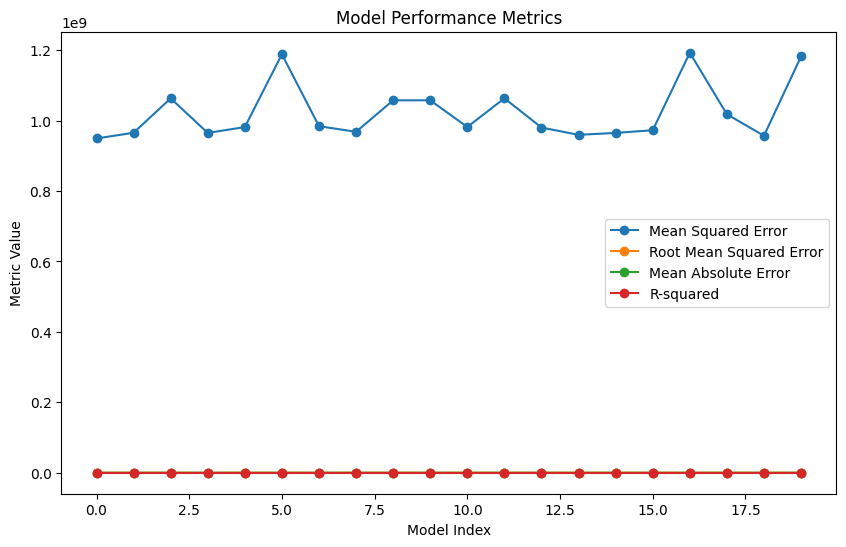

In [77]:
plt.figure(figsize=(10, 6))

for column in ['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']:
   plt.plot(hdf.index, hdf[column], marker='o', label=column)

plt.xlabel('Model Index')
plt.ylabel('Metric Value')
plt.title('Model Performance Metrics')
plt.legend()
plt.show()

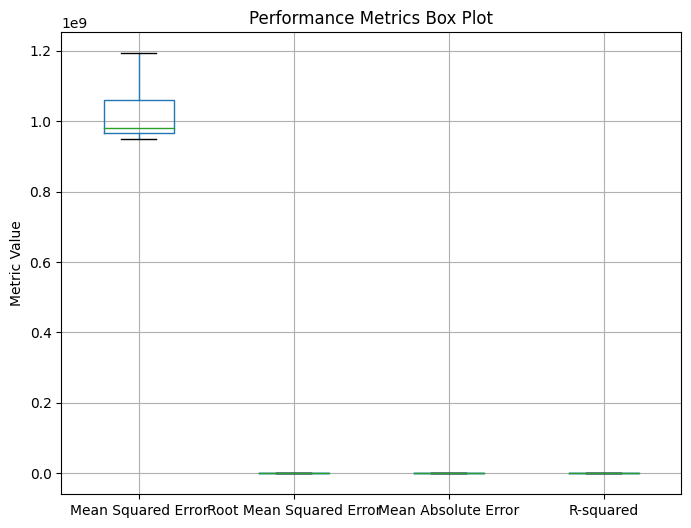

In [80]:
plt.figure(figsize=(8, 6))
hdf[['Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-squared']].boxplot()
plt.title('Performance Metrics Box Plot')
plt.ylabel('Metric Value')
plt.show()


### Step 5: Updated Baseline Model

- Training and evaluating a new baseline model using the best hyperparameters obtained from the Random Grid Search above.
- Record performance metrics (MSE, RMSE, MAE, R2) and computation time for this updated baseline model.

Training and evaluating a new baseline model using the best hyperparameters obtained from the Random Grid Search: 

In [27]:
# Defining and training a new baseline Random Forest model with the best obtained hyperparameters from Random Grid Search
best_hyperparameters = {
    'n_estimators': 50,  
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'bootstrap': True
    # 'random_state': 42
}

baseline_model = RandomForestRegressor(**best_hyperparameters)

# Start time
start_time = time.time()

baseline_model.fit(X_train, y_train)

# Making predictions with the new baseline model
y_baseline_pred = baseline_model.predict(X_test)

# End time
end_time = time.time()

# Calculating evaluation metrics for the new baseline model
mse_baseline = mean_squared_error(y_test, y_baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_baseline_pred)
r2_baseline = r2_score(y_test, y_baseline_pred)

# computation time
computation_time_baseline = end_time - start_time

print(f"Mean Squared Error (Updated Baseline): {mse_baseline}")
print(f"Root Mean Squared Error (Updated Baseline): {rmse_baseline}")
print(f"Mean Absolute Error (Updated Baseline): {mae_baseline}")
print(f"R-squared (Updated Baseline): {r2_baseline}")
print(f"Computation Time (Updated Baseline): {computation_time_baseline} seconds")


Mean Squared Error (Updated Baseline): 983362432.4728016
Root Mean Squared Error (Updated Baseline): 31358.610180822772
Mean Absolute Error (Updated Baseline): 4446.774665797387
R-squared (Updated Baseline): 0.2883763726985359
Computation Time (Updated Baseline): 3.154067039489746 seconds


Here:

A new baseline for Random Forest regressor model was created using the best hyperparameters obtained from Random Grid Search.<p>
The model was trained using the training data.
Made predictions on the test data and calculated evaluation metrics (MSE, RMSE, MAE, R2) for the new baseline model.
Measured the computation time it took for training and evaluation and printed the results.
Basically, Step 5 involved training and evaluating a new baseline model with the optimized hyperparameters from step 4. 

### Step 6: Surrogate Model Training

- XGBoost surrogate model was choosen for the next part of the experiment.
- Training the surrogate model using some shared hyperparameters and their corresponding performance metrics from the Random Grid Search.

In [82]:
# Defining the hyperparameters used in surrogate model training
surrogate_hyperparameters = {
    'objective': 'reg:squarederror',
    'n_estimators': 50,
    'max_depth': 10,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Creating an XGBoost regressor with the hyperparameters above
xgb_model = XGBRegressor(**surrogate_hyperparameters)

# Start time
start_time = time.time()

# Training the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Making predictions using the XGBoost model
y_xgb_pred = xgb_model.predict(X_test)

# End time
end_time = time.time()

# Calculating evaluation metrics for the surrogate model
mse_xgb = mean_squared_error(y_test, y_xgb_pred)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_xgb_pred)
r2_xgb = r2_score(y_test, y_xgb_pred)

# computation time
computation_time_xgb = end_time - start_time

print(f"Mean Squared Error (XGBoost): {mse_xgb}")
print(f"Root Mean Squared Error (XGBoost): {rmse_xgb}")
print(f"Mean Absolute Error (XGBoost): {mae_xgb}")
print(f"R-squared (XGBoost): {r2_xgb}")
print(f"Computation Time (XGBoost): {computation_time_xgb} seconds")


Mean Squared Error (XGBoost): 969627369.2013134
Root Mean Squared Error (XGBoost): 31138.84020321427
Mean Absolute Error (XGBoost): 3516.807428161621
R-squared (XGBoost): 0.2983159384412427
Computation Time (XGBoost): 0.5679266452789307 seconds


Here: 

Surrogate_hyperparameters was defined. 
An XGBoost regressor was created using these hyperparameters. 
The XGBoost model was trained using the training dataset. 
Predictions were made, and the surrogate model's performance was assessed through metrics including MSE, RMSE, MAE, R2, and computation time.
When the surrogate model is used without hyperparameter optimization, the results seem superior to those of the baseline model with optimized hyperparameters.

### Step 7: Surrogate-Guided Hyperparameter Optimization
Here:
- Using the surrogate model to predict the performance of different hyperparameter configurations sampled randomly.
- Recorded the best hyperparameter settings and the corresponding performance metrics.

Performing Surrogate-Guided Hyperparameter Optimization using the XGBoost surrogate 

In [83]:
# To ignore XGBoost warnings
warnings.filterwarnings("ignore", category=UserWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defining the search space for hyperparameters
search_space = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Number of sampled random hyperparameters through iteration 
num_samples = 20  

# Initializing a list to store the sampled hyperparameters
sampled_hyperparameters = []

# Populating the list of randomly sampled hyperparameters.
for _ in range(num_samples):
    random_hyperparams = {
        'n_estimators': random.choice(search_space['n_estimators']),
        'max_depth': random.choice(search_space['max_depth']),
        'learning_rate': random.choice(search_space['learning_rate']),
        'subsample': random.choice(search_space['subsample']),
        'colsample_bytree': random.choice(search_space['colsample_bytree'])
    }
    sampled_hyperparameters.append(random_hyperparams)

# Creating empty lists to store the performance metrics
mse_scores = []
rmse_scores = []
mae_scores = []
r2_scores = []

# Creating an empty list to store the predicted scores
predicted_scores = []

# Predicting with the surrogate model (XGBoost)
for hyperparameters in sampled_hyperparameters:
    # Creating XGBoost regressor with specified hyperparameters above
    xgb_params = {
        'objective': 'reg:squarederror',
        'n_estimators': hyperparameters['n_estimators'],
        'max_depth': hyperparameters['max_depth'],
        'learning_rate': hyperparameters['learning_rate'],
        'subsample': hyperparameters['subsample'],
        'colsample_bytree': hyperparameters['colsample_bytree']
    }
    
    xgb_model = xgb.XGBRegressor(**xgb_params)  
    
    # Start time 
    start_time = time.time()
    
    # Training XGBoost model 
    xgb_model.fit(X_train, y_train)
    
    # Making predictions 
    y_xgb_pred = xgb_model.predict(X_test)
    
    # Calculating the performance metrics
    mse_xgb = mean_squared_error(y_test, y_xgb_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    mae_xgb = mean_absolute_error(y_test, y_xgb_pred)
    r2_xgb = r2_score(y_test, y_xgb_pred)
    
    # End time for computation
    end_time = time.time()
    
    # computation time
    computation_time_xgb = end_time - start_time
    
    # Appending metrics to lists
    mse_scores.append(mse_xgb)
    rmse_scores.append(rmse_xgb)
    mae_scores.append(mae_xgb)
    r2_scores.append(r2_xgb)

    # Adding the performance score to the list
    predicted_scores.append(mse_xgb)

# Finding the hyperparameters with the best predicted score (i.e. lowest MSE)
best_hyperparameters_idx = np.argmin(predicted_scores)
best_hyperparameters = sampled_hyperparameters[best_hyperparameters_idx]

print("Best Hyperparameters:", best_hyperparameters)
print(f"Mean Squared Error (Best Model): {mse_scores[best_hyperparameters_idx]}")
print(f"Root Mean Squared Error (Best Model): {rmse_scores[best_hyperparameters_idx]}")
print(f"Mean Absolute Error (Best Model): {mae_scores[best_hyperparameters_idx]}")
print(f"R-squared (Best Model): {r2_scores[best_hyperparameters_idx]}")
print(f"Computation Time (XGBoost): {computation_time_xgb} seconds")


Best Hyperparameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.8}
Mean Squared Error (Best Model): 837715711.1928844
Root Mean Squared Error (Best Model): 28943.3189387963
Mean Absolute Error (Best Model): 3265.275557722092
R-squared (Best Model): 0.393775607689798
Computation Time (XGBoost): 0.42394590377807617 seconds


Using the trained surrogate model, a surrogate-guided hyperparameter optimization process was initiated. The surrogate model predicted the performance of different configurations. The hyperparameter configuration with the best-predicted performance was selected. The experiment recorded the best hyperparameters identified through this surrogate-guided optimization, along with the corresponding performance metrics.